In [1]:
from data_preprocessing.cleaning import clean_audio_folder
from data_preprocessing.augmentation.audio import augment_audio_files
from data_preprocessing.merging import merge_audios_by_speakers
from data_preprocessing.splitting import split_audio_files
from data_preprocessing.spectrogram_converter import convert_audio_files_to_images
from data_preprocessing.spectrogram_sharpener import sharpen_spectrograms

%load_ext autoreload
%autoreload 2

C:\Users\micha\.virtualenvs\intro-to-ml-venv\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [3]:
import glob
from math import sqrt
import re
from typing import Dict, List

from matplotlib import pyplot as plt
from tqdm import tqdm


files = glob.glob("../data/tsrc/train/**/*.wav", recursive=True)
files_string = "\n".join(files)
word_speaker_to_files: Dict[str, List[str]] = {}



for file in tqdm(files):
    word = file.split("\\")[-2]
    speaker = file.split("\\")[-1].split(".")[-2].split("_")[0]

    word_speaker_key = f"{word}_{speaker}"

    if word_speaker_key in word_speaker_to_files:
        continue

    word_speaker_files = re.findall(rf'{word}\\{speaker}', files_string)
    word_speaker_to_files[word_speaker_key] = len(word_speaker_files)

file_occurances = [files_count for files_count in word_speaker_to_files.values()]

0it [00:00, ?it/s]


Text(0.5, 0, 'Count of different versions of same audio')

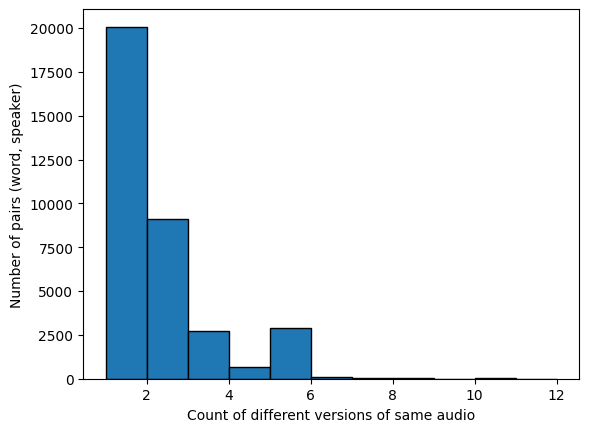

In [75]:
plt.hist(file_occurances, bins=11, edgecolor='black')
plt.ylabel('Number of pairs (word, speaker)')
plt.xlabel('Count of different versions of same audio')

In [73]:
import numpy as np


values, bins = np.histogram(file_occurances, bins=11)
print(values)
print(bins)

[20073  9080  2726   668  2902    80    31    24     8    15     2]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]


(array([ 38.,   0.,  13.,   0.,  10.,   0.,  13.,   0.,   7.,   0.,  11.,
          0.,   8.,   0.,   7.,   0.,   6.,   0.,   7.,   0.,   8.,   0.,
          9.,   0.,   9.,   0.,  12.,   0.,  26.,   0.,   0.,  79.,   0.,
        162.,   0., 260.,   0., 385.,   0., 310.,   0., 223.,   0.,  88.,
          0.,  32.,   0.,   3.,   0.,   1.,   0.,   4.,   0.,   3.,   0.,
          1.,   0.,   9.,   0., 137.]),
 array([ 1.        ,  1.48333333,  1.96666667,  2.45      ,  2.93333333,
         3.41666667,  3.9       ,  4.38333333,  4.86666667,  5.35      ,
         5.83333333,  6.31666667,  6.8       ,  7.28333333,  7.76666667,
         8.25      ,  8.73333333,  9.21666667,  9.7       , 10.18333333,
        10.66666667, 11.15      , 11.63333333, 12.11666667, 12.6       ,
        13.08333333, 13.56666667, 14.05      , 14.53333333, 15.01666667,
        15.5       , 15.98333333, 16.46666667, 16.95      , 17.43333333,
        17.91666667, 18.4       , 18.88333333, 19.36666667, 19.85      ,
      

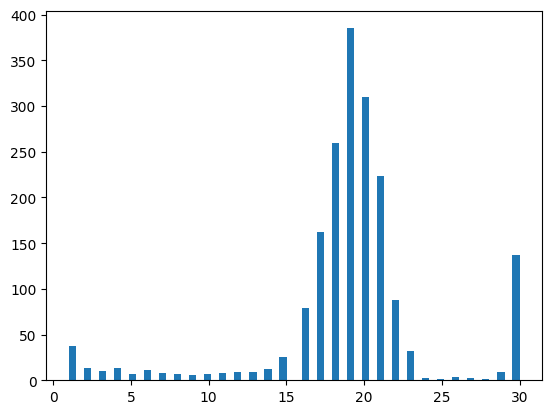

In [ ]:
import glob
from typing import Dict, List

from matplotlib import pyplot as plt


files = glob.glob("../data/tsrc/train/**/*_nohash_0.wav", recursive=True)
word_speaker_to_files: Dict[str, List[str]] = {}

for file in files:
    hash_id = file.split("\\")[-1].split("_")[-3]
    if hash_id not in word_speaker_to_files:
        word_speaker_to_files[hash_id] = []
    word_speaker_to_files[hash_id].append(file)


file_occurances = [len(files) for files in word_speaker_to_files.values()]
plt.hist(file_occurances, bins=60)

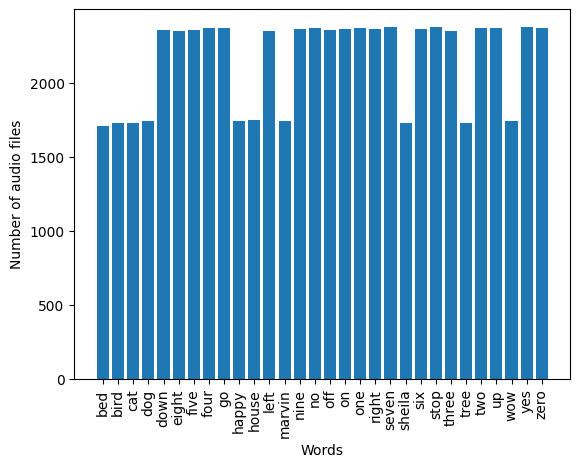

In [7]:
import glob
import os
from typing import Dict, List

from matplotlib import pyplot as plt

word_to_audio_files: Dict[str, List[str]] = {}

for word in os.listdir('../data/tsrc/train/audio'):
    if word == '_background_noise_':
        continue
    word_to_audio_files[word] = glob.glob(f"../data/tsrc/train/audio/{word}/*.wav")


file_occurances = [len(files) for files in word_to_audio_files.values()]
plt.bar(word_to_audio_files.keys(), file_occurances)
plt.xticks(rotation=90)
plt.ylabel('Number of audio files')
plt.xlabel('Words')
plt.show()

In [5]:
import os

In [12]:
os.path.normpath("../data/tsrc_train_test/train/bed/6d818f6c_nohash_2.wav").split('/')

['..', 'data', 'tsrc_train_test', 'train', 'bed', '6d818f6c_nohash_2.wav']

In [6]:
from functools import partial
from data_preprocessing.augmentation import compose
from data_preprocessing.augmentation import audio
from backend.spectrograms.utils import AudioLoader

transformations = compose.Compose([
    (partial(audio.addNoise, noiseThreshold=0.005), 0.5)
])

#audioData = AudioLoader().load_data(os.path.join('../data/tsrc_train_test', 'train', 'bed'))

In [7]:
import random
import numpy as np
from data_preprocessing.train_test_split import train_test_split

random.seed(42)
np.random.seed(42)

train_test_split(
    '../data/tsrc/train/audio', 
    '../data/tsrc_train_test', 
)

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [03:31<00:00,  6.83s/it]


In [15]:
import os

In [17]:
os.path.normpath(r"../data/tsrc_train_test\test\bed").split('\\')

['..', 'data', 'tsrc_train_test', 'test', 'bed']

In [17]:
a = "train"

In [22]:
os.path.join("../data/tsrc_augmented", "train")

'../data/tsrc_augmented\\train'

zrobić balancowanie klas

In [18]:
audio.augment_audio_files('../data/tsrc_train_test', '../data/tsrc_augmented2', transformations, 2500)
# clean_audio_folder('../data/tsrc_train_test', '../data/tsrc_cleaned')
# merge_audios_by_speakers('../data/tsrc_cleaned', '../data/tsrc_merged')
# split_audio_files('../data/tsrc_merged', '../data/tsrc_splitted')
# convert_audio_files_to_images("../data/tsrc_cleaned", "../data/tsrc_sprectrograms_cleaned")
# sharpen_spectrograms("../data/tsrc_sprectrograms_cleaned", "../data/tsrc_spectrograms_cleaned_sharpened")

Loading audio files... ../data/tsrc_train_test\train\bed


100%|█████████████████████████████████████████████████████████████████████████████| 1222/1222 [00:01<00:00, 941.22it/s]


Augmenting train
env:bed COUNT: 1222
env:bird COUNT: 0
No files found in loaded dataset for env: bird
Copying over test and validation sets


4it [00:00,  4.21it/s]


KeyboardInterrupt: 